In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate
from tqdm.auto import tqdm
import seaborn as sns

import wandb


In [2]:
sns.set_theme()
plt.rc('figure', figsize=(8, 4), dpi=100)


# Set up Weights & Biases tracking

To make this interesting, we're tracking everyone's progress via W&B. Don't worry 
Please replace `<Your name here>` by your own name (or a nickname).

If you just want to play around without uploading your runs, set `offline` to `True`

In [3]:
# Used for identifying runs on the W&B dashboard
# name = "<Your name here>"
name = "Vincent Brouwers"

# Whether or not to upload runs to W&B
upload = True

# Just for tracking your
run = 0

In [4]:
if name == "<Your name here>":
  raise Exception("RTFM")

# Load Data

In [5]:
run += 1

In [6]:
df = pd.read_csv("datasets/full.csv")
all_feature_names = df.iloc[:, 1:].columns.to_list()

class Dataset:
  """
  Just a small wrapper to emulate around Scikit-learn's built-in datasets
  """
  def __init__(self, df):
    data = df.iloc[:, 1:]
    target = df.iloc[:, 0]
    self.data = data.to_numpy()
    self.target = target.to_numpy()
    self.feature_names = data.columns.to_list()    
    self.target_names = ["not buggy", "buggy"]
    
data = Dataset(df)

X = data.data
y = data.target
feature_names = data.feature_names
labels = data.target_names

In [7]:
# Split data into 70% train and 30% test subsets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=True,
)

In [12]:
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

## Defining our models

The value of features can differ greatly between models, which is why we test across a number of common and easy-to-train ones. We also look at the effect of regularization, as this can also affect the impact of feature selection.

* Decision Tree
* Random Forrest
* Logistic Regression
* Logistic Regression (with L1 regularization)
* Logistic Regression (with L2 regularization)


_There is no need to change anything here. These are just helper functions to quickly test our data_

In [30]:
classifiers = [
        (DecisionTreeClassifier(), ),
        (RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_depth=20, class_weight="balanced"), ),
        # (SVC(gamma="auto", probability=True, class_weight=class_weight), ),
        (LogisticRegression(max_iter=1000, class_weight="balanced"), ),
        (LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear", class_weight="balanced"), "_l1"),
        (LogisticRegression(max_iter=1000, penalty="l2", class_weight="balanced"), "_l2"),
    ]
classifiers = [(c[0], c[0].__class__.__name__ + (c[1] if len(c) > 1 else "")) for c in classifiers]

In [33]:
baseline = None

def test_classifier(clf, feature_indices):
    if not feature_indices:
        feature_indices = list(range(X_train.shape[1]))
    clf.fit(X_train[:, feature_indices], y_train)

    # predicted = clf.predict(X_test)
    y_probas = clf.predict_proba(X_test[:, feature_indices])
    y_pred = y_probas.argmax(axis=1)

    scores = {
        f"Accuracy": metrics.accuracy_score(y_test, y_pred),
        f"F1": metrics.f1_score(y_test, y_pred),
        f"Precision": metrics.precision_score(y_test, y_pred),
        f"Recall": metrics.recall_score(y_test, y_pred),
    }
    return scores, y_probas
  
def test_selection(feature_indices, compare=True, log=True, log_wandb=False):
    kwargs = dict(feature_indices=feature_indices, log=False, log_wandb=False)
    
    scores = {}
    table = []
    for classifier, name in tqdm(classifiers, smoothing=0):
        scores_ = test_classifier(classifier, feature_indices=feature_indices)[0]
        scores[name] = scores_
        
        fmt = {m: f"{s:0.4f}" + (f"{baseline[name][m]:0.4f}" if compare else "") for m, s in scores_.items()}
        table.append(fmt)
    
        

    # for n_score, b_score in zip(scores, baseline or range(len(scores))):

    #     if compare:
    #         print(n_score)
    #         print(b_score)
    #         n_score = [f"{n:0.4f} ({n - b:.04f})" for n, b in zip(n_score, b_score)]
                    
    #     table.append([name, *n_score])
    
    print(table)
    # print(tabulate(table, headers=["Classifier", "Accuracy", "F1", "Precision", "Recall"]))   
    tabulate(table, headers="key")
        
        
    return scores    
    
baseline = test_selection(None, compare=False)

  0%|          | 0/5 [00:00<?, ?it/s]

[{'Accuracy': '0.7667', 'F1': '0.6112', 'Precision': '0.6810', 'Recall': '0.5544'}, {'Accuracy': '0.7697', 'F1': '0.6703', 'Precision': '0.6365', 'Recall': '0.7078'}, {'Accuracy': '0.7616', 'F1': '0.5779', 'Precision': '0.6972', 'Recall': '0.4935'}, {'Accuracy': '0.7613', 'F1': '0.5773', 'Precision': '0.6969', 'Recall': '0.4927'}, {'Accuracy': '0.7616', 'F1': '0.5779', 'Precision': '0.6972', 'Recall': '0.4935'}]


ValueError: headers for a list of dicts is not a dict or a keyword

In [ ]:
baseline = None

def test_classifier(clf, feature_indices):
    if not feature_indices:
        feature_indices = list(range(X_train.shape[1]))
    clf.fit(X_train[:, feature_indices], y_train)

    # predicted = clf.predict(X_test)
    y_probas = clf.predict_proba(X_test[:, feature_indices])
    y_pred = y_probas.argmax(axis=1)

    scores = {
        f"Accuracy": metrics.accuracy_score(y_test, y_pred),
        f"F1": metrics.f1_score(y_test, y_pred),
        f"Precision": metrics.precision_score(y_test, y_pred),
        f"Recall": metrics.recall_score(y_test, y_pred),
    }
    return scores, y_probas
  
def test_selection(feature_indices, compare=True, log=True, log_wandb=False):
    kwargs = dict(feature_indices=feature_indices, log=False, log_wandb=False)
    
    scores = {}
    table = []
    for classifier, name in tqdm(classifiers, smoothing=0):
        scores_ = test_classifier(classifier, feature_indices=feature_indices)[0]
        scores[name] = scores_
        
        fmt = {m: f"{s:0.4f}" + f"{baseline[name][metric]:0.4f}" if compare else "" for m, s in scores_.items()}
        if compare:
            fmt = {m: f"{score:0.4f}" for metric, score in scores_.items()}
        table.append()
        
        for metric, score in scores_:
            rep = f"{score:0.4f}"
            if compare:
                rep += f"{baseline[name][metric]:0.4f}"
            


    for clf, clf_scores in scores.items():
        if compare:
            b_scores = baseline[clf]
        
        

    for n_score, b_score in zip(scores, baseline or range(len(scores))):

        if compare:
            print(n_score)
            print(b_score)
            n_score = [f"{n:0.4f} ({n - b:.04f})" for n, b in zip(n_score, b_score)]
                    
        table.append([name, *n_score])
    
    
    # print(tabulate(table, headers=["Classifier", "Accuracy", "F1", "Precision", "Recall"]))   
    tabulate(table, headers="key")
        
        
    return scores    
    
baseline = test_selection(None, compare=False)

  0%|          | 0/5 [00:00<?, ?it/s]

Classifier               Accuracy        F1    Precision    Recall
---------------------  ----------  --------  -----------  --------
LogisticRegression_l2    0.766443  0.612299     0.678854  0.55763
LogisticRegression_l2    0.769396  0.669996     0.636032  0.707792
LogisticRegression_l2    0.761611  0.577947     0.697248  0.493506
LogisticRegression_l2    0.761342  0.577271     0.6969    0.492695
LogisticRegression_l2    0.761611  0.577947     0.697248  0.493506


## Feature Selection

In [28]:
baseline = test_selection(None)

  0%|          | 0/5 [00:00<?, ?it/s]

dict_values([0.7629530201342282, 0.6084257206208425, 0.6705767350928641, 0.5568181818181818])
dict_values([0.7624161073825504, 0.6057906458797327, 0.6712734452122409, 0.551948051948052])
dict_values([0.7685906040268456, 0.668206312548114, 0.6354319180087847, 0.7045454545454546])
dict_values([0.7702013422818792, 0.6725325172149962, 0.6360347322720694, 0.713474025974026])
dict_values([0.7616107382550336, 0.5779467680608366, 0.6972477064220184, 0.4935064935064935])
dict_values([0.7616107382550336, 0.5779467680608366, 0.6972477064220184, 0.4935064935064935])
dict_values([0.7613422818791946, 0.5772705658582977, 0.6969001148105626, 0.4926948051948052])
dict_values([0.7613422818791946, 0.5772705658582977, 0.6969001148105626, 0.4926948051948052])
dict_values([0.7616107382550336, 0.5779467680608366, 0.6972477064220184, 0.4935064935064935])
dict_values([0.7616107382550336, 0.5779467680608366, 0.6972477064220184, 0.4935064935064935])
Classifier             Accuracy          F1                Prec

### Variance Threshold

A simple method to filter out superfluous features, is to remove ones with a low variance. The idea here is that these features offer relatively little information.

In [15]:
from sklearn.feature_selection import VarianceThreshold

var = VarianceThreshold(threshold=0.3)

var.fit(X_train)

used_features = var.get_support()
used_feature_names = var.get_feature_names_out(data.feature_names)
print(f"Selected {sum(used_features)}/{len(feature_names)} features: \n{used_feature_names}")

# X_reduced = var.transform(X_train)
test_selection(used_features)


Selected 19/23 features: 
['h1' 'h2' 'N1' 'N2' 'complexity' 'loc' 'lloc' 'sloc' 'comments' 'multi'
 'blank' 'single_comments' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_of_modified_python_files' 'no_of_deleted_files'
 'no_of_deleted_python_files']


  0%|          | 0/5 [00:00<?, ?it/s]

Classifier                Accuracy        F1    Precision    Recall
----------------------  ----------  --------  -----------  --------
DecisionTreeClassifier    0.762416  0.605439     0.671612  0.551136
RandomForestClassifier    0.764564  0.666159     0.62724   0.710227
LogisticRegression        0.762148  0.578497     0.698851  0.493506
LogisticRegression_l1     0.761879  0.57782      0.698504  0.492695
LogisticRegression_l2     0.762148  0.578497     0.698851  0.493506


### From model

Some models have built-in methods of extracting the importance of each feature. This allows us to easily remove the fields that our model extracts the least amount of information from

Selected 18/23 features: 
['h1' 'h2' 'N1' 'N2' 'complexity' 'loc' 'lloc' 'sloc' 'comments' 'multi'
 'blank' 'single_comments' 'no_of_files' 'no_of_added_files'
 'no_of_modified_files' 'no_of_modified_python_files'
 'no_of_deleted_files' 'no_of_deleted_python_files']


  0%|          | 0/5 [00:00<?, ?it/s]

Classifier                Accuracy        F1    Precision    Recall
----------------------  ----------  --------  -----------  --------
DecisionTreeClassifier    0.764832  0.611358     0.674168  0.559253
RandomForestClassifier    0.76349   0.664636     0.625806  0.708604
LogisticRegression        0.761074  0.576996     0.696101  0.492695
LogisticRegression_l1     0.761074  0.576996     0.696101  0.492695
LogisticRegression_l2     0.761074  0.576996     0.696101  0.492695


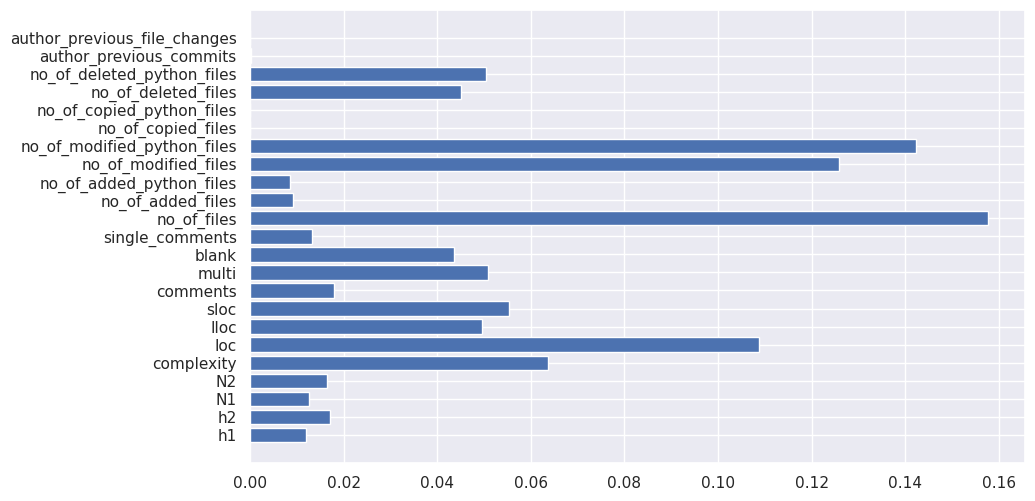

In [16]:
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.barh(feature_names, clf.feature_importances_)

selector = SelectFromModel(clf, threshold="0.2 * mean", prefit=True)

used_features = selector.get_support()
used_feature_names = selector.get_feature_names_out(data.feature_names)
print(f"Selected {sum(used_features)}/{len(feature_names)} features: \n{used_feature_names}")

test_selection(used_features)

In [ ]:
# %%wandb

# run += 1

# used_features = [[name, name in all_feature_names] for name in data.feature_names]
used_features = {name: name in data.feature_names for name in all_feature_names}

wandb.init(
    project="sogeti-hackathon-feature-selection",
    entity="vincentbrouwers",
    name=f"{name}-run {run}",
    anonymous="allow",
    tags=dict(name=name, run=run),
    mode="online" if upload else "offline",
    config=dict(features=used_features)
)

y_probas = clf.predict_proba(X_test)
y_pred = y_probas.argmax(axis=1)    

# wandb.log(
#     {
#         "conf_mat": wandb.plot.confusion_matrix(
#             y_probas, y_test, class_names=data.target_names
#         )
#     }
# )
# wandb.log()
wandb.log(
    {
        "feature_count": len(data.feature_names),
        "used_features": wandb.Table(
            columns=["feature", "used"],
            # Just temporary until I have an actual method of filtering features
            data=list(used_features.items()),
        ),
        "roc": wandb.plot.roc_curve(y_test, y_probas, data.target_names),
        "pr": wandb.plot.pr_curve(y_test, y_probas, data.target_names),
    }
)

wandb.finish()


feature_count,▁
feature_count,19


## Test your solution

At the end of the hackathon, you will all receive a withheld test set to test your solutions on. You will be scored on how many features you use and the accuracy difference of our models after training on your reduced feature set.